# Titanic Top 4% with ensemble modeling  
  


In [461]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from collections import Counter
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style = 'white', context='notebook', palette = 'deep')

# Load and check data

## Load data

In [462]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
IDtest = test['PassengerId']

In [463]:
train.shape, test.shape

((891, 12), (418, 11))

## Outlier detection

In [464]:
def detect_outliers(df,n,features):
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
        
    return multiple_outliers
    
Outliers_to_drop = detect_outliers(train,2,["Age", "SibSp", "Parch", "Fare"])

수치 피처에서 이상치를 검출  
적어도 두개의 이상치를 갖는 행을 이상치로 간주

In [465]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


10개의 이상치를 찾았다  
28,89,342번의 승객들은 높은 티켓값을  
나머지 승객들은 높은 SibSp를 가지고 있다

In [466]:
# drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

## joining train and test set

In [467]:
train_len = len(train)
dataset = pd.concat(objs = [train, test], axis=0).reset_index(drop=True)

In [468]:
train.shape, test.shape

((881, 12), (418, 11))

((891, 12), (418, 11)) -> ((881, 12), (418, 11))  
outlier 10 rows removed

## check for null and missing values

In [469]:
# fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# check for null 
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Age, Cabin 결측치가 많다  
Survived의 결측치는 test set의 결측치

In [470]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [471]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [472]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [473]:
# Sunnarize data
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# Feature analysis

## Numerical values

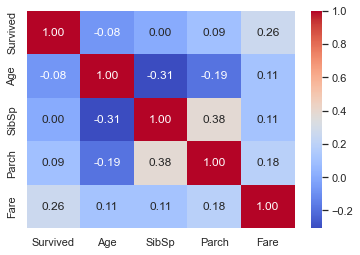

In [474]:
# Correlation Matrix
g = sns.heatmap(train[['Survived', 'Age', 'SibSp', 'Parch', 'Fare']].corr(), 
                      annot=True, fmt=".2f", cmap = 'coolwarm' )

Fare, Survived의 상관관계가 가장 크게 나옴 

### SibSp

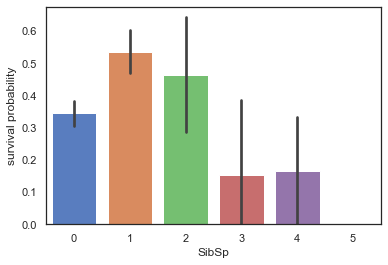

In [475]:
g = sns.barplot(data = train, x = 'SibSp', y = 'Survived',palette = "muted")
#g.despine(left=True)
g = g.set(ylabel='survival probability')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


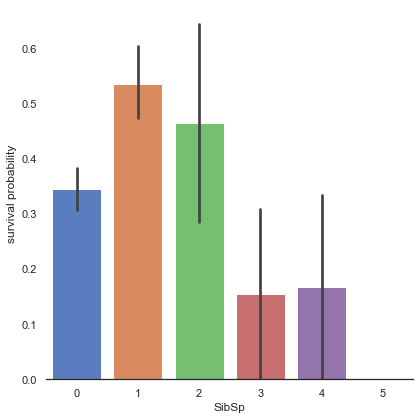

In [476]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

형제자매가 많은 승객의 생존율은 낮다  
1,2인 승객이 생존가능성 높다  

### Parch

[Text(0, 0.5, 'survival probability')]

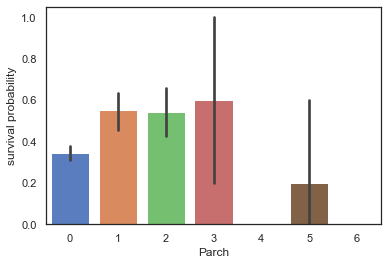

In [477]:
g = sns.barplot(data = train, x = 'Parch', y = 'Survived', palette = 'muted')
g.set(ylabel = 'survival probability')

0 : 독신  
1,2,3일때 생존율이 높다

### Age

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


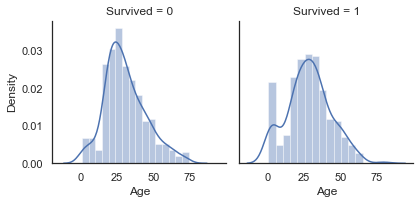

In [478]:
g = sns.FacetGrid(data = train, col = 'Survived')
g.map(sns.distplot,'Age')

나이 분포는 꼬리분포, 가우시안 분포일 수 있다  
  
어린 승객의 생존율이 높다  
75세 이상 승객의 생존율은 낮다

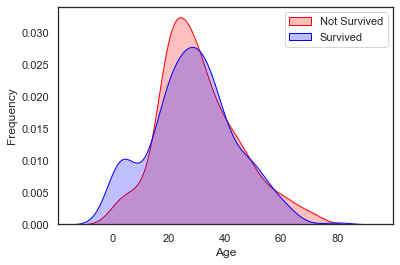

In [479]:
g = sns.kdeplot(train['Age'][(train['Survived']==0)&(train['Age'].notnull())], color="Red", shade=True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set(xlabel = 'Age', ylabel='Frequency')
g.legend(['Not Survived','Survived'])

아주 어린 승객들에서 생존율 차이가 크게 난다

### Fare

In [480]:
dataset["Fare"].isnull().sum()

1

In [481]:
dataset[dataset["Fare"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1033,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [482]:
# fill Fare missing values with the median value
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


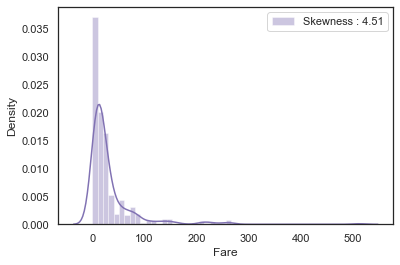

In [483]:
g = sns.distplot(dataset['Fare'], color='m', label='Skewness : %.2f'%(dataset['Fare'].skew()))
# legend 위치 설정
g.legend(loc = 'best')

Fare분포는 매우 치우쳐 있다  
로그함수로 변환하여 skew를 줄이는 것이 좋다

skew : 왜도, 비대칭도  
평균에 대해 최빈값이 얼마나 치우쳐져있는지를 나타내는 척도
우측으로 치우칠수록 음의 값  
좌측으로 치우칠수록 양의 값

In [484]:
# apply log to Fare to reduce skewness distribution
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


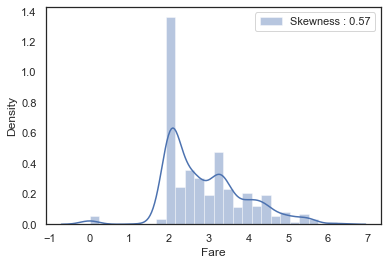

In [485]:
g = sns.distplot(dataset['Fare'], color = 'b', label='Skewness : %.2f'%(dataset['Fare'].skew()))
g.legend(loc='best')

## Categorical values

### Sex

[Text(0, 0.5, 'Survival probability')]

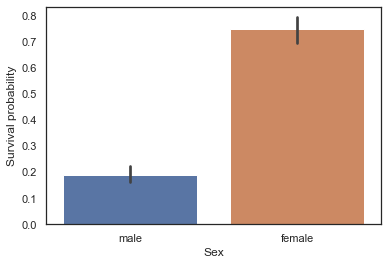

In [486]:
g = sns.barplot(data = train, x = 'Sex', y = 'Survived')
g.set(ylabel='Survival probability')

In [487]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


남자가 여자보다 생존율 낮음  - 명확하게 보임  
Sex는 중요한 특징일 수 있다  

### Pclass

[Text(0, 0.5, 'Survival probability')]

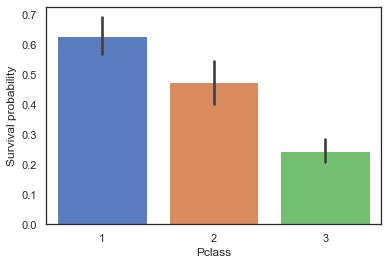

In [488]:
g = sns.barplot(data = train, x = 'Pclass', y = 'Survived', palette='muted')
#g.despine(left=True)
g.set(ylabel='Survival probability')

[Text(0, 0.5, 'Survival probability')]

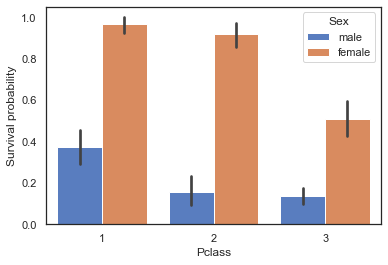

In [489]:
# Pclass vs Survived by sex
g = sns.barplot(data = train, x = 'Pclass', y = 'Survived', hue = 'Sex', palette='muted')
g.set(ylabel='Survival probability')

일등석 승객의 생존율이 가장 높다 - 성별에 관계없이

### Embarked

In [490]:
dataset['Embarked'].isnull().sum()

2

In [491]:
dataset['Embarked'].value_counts()

S    904
C    270
Q    123
Name: Embarked, dtype: int64

In [492]:
# fill nan values of frequent value
dataset['Embarked'] = dataset['Embarked'].fillna('S')

[Text(0, 0.5, 'Survival probability')]

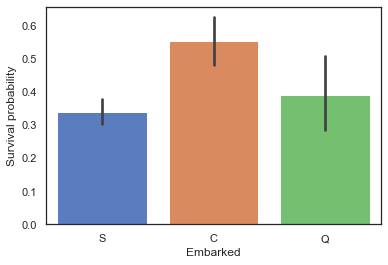

In [493]:
g = sns.barplot(data = train, x = 'Embarked', y = 'Survived', palette='muted')
g.set(ylabel='Survival probability')

C에서 오는 승객의 생존 가능성이 높아보임  
일등석 승객 비율이 C가 많을 것으로 예상

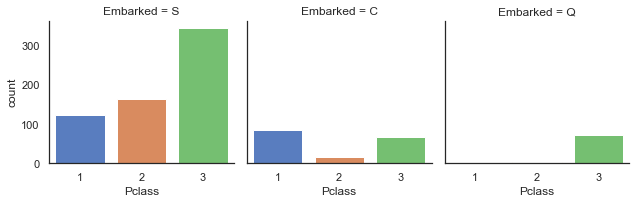

In [494]:
# Pclass vs Embarked
g = sns.FacetGrid(data = train, col = 'Embarked')
g.map_dataframe(sns.countplot, x = 'Pclass', palette = 'muted')

S, Q 에서 오는 승객은 3등석이 가장 많은 반면 C 탑승객은 1등석이 많다  
일등석 승객들이 우선순위로 빠져나갔을 가능성 있음

# Fillng missing values

## Age

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.wa

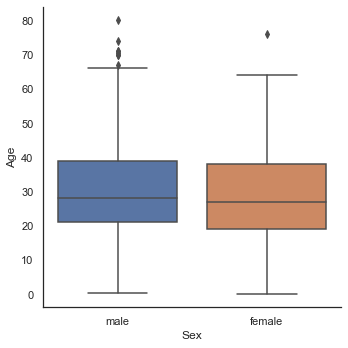

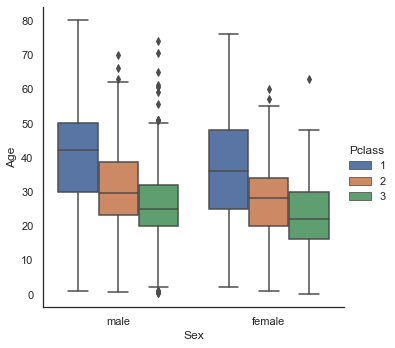

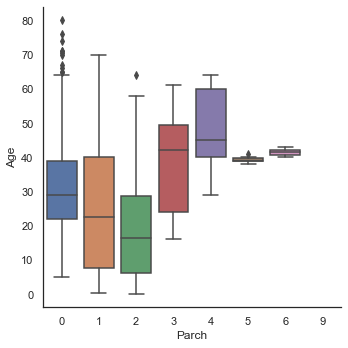

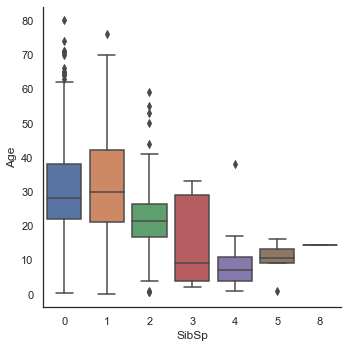

In [495]:
# 256 missing vaiues
g = sns.factorplot(y="Age",x="Sex",data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=dataset,kind="box")

성별정보는 나이를 예측하는데 도움이 안됨  
일등석 승객들이 나이가 많다  
부모/자녀가 많을수록 나이가 많다  
형제/배우자가 많을수록 나이가 적다

In [496]:
# convert Sex into Categorical value
dataset['Sex'] = dataset['Sex'].map({"male" :0, "female" :1})

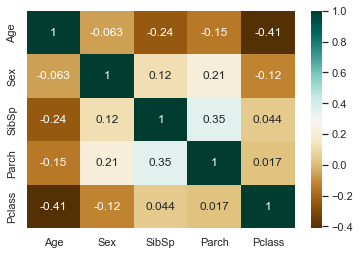

In [497]:
g = sns.heatmap(dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

나이는 성별과 상관관계 없지만 나머지와는 음의 상관관계가 있음  
 boxplot에서 Parch와 나이는 양의 상관관계를 보였으나 heatmap plot에선 음의 상관관계를 보임  
 class, Parch, SibSp에 따라 Age를 행의 중앙값으로 채우겠다

In [498]:
# filling missing value of Age

# index of NaN age rows
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp'])&
                               (dataset['Parch'] == dataset.iloc[i]['Parch'])&
                               (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:xlabel='Survived', ylabel='Age'>

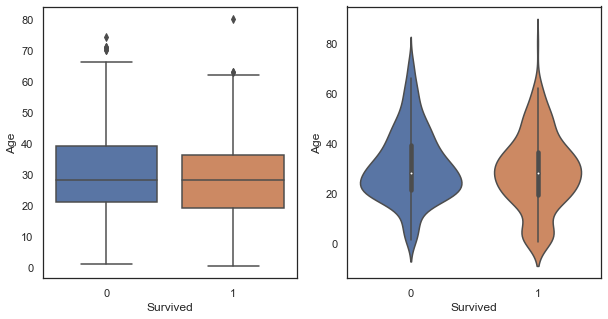

In [499]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.boxplot(data=train, x = 'Survived', y = 'Age')
plt.subplot(1,2,2)
sns.violinplot(data=train, x = 'Survived', y = 'Age')

생존한 사람들과 생존하지 못한 사람들의 나이 중앙값은 차이가 없다  
바이올린 플랏에서 매우 어린 승객들의 생존율이 높음을 볼 수 있다

# Feature engineering

## Name / Title

In [500]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [501]:
# get title from Name
dataset_title = [i.split(',')[1].split(".")[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

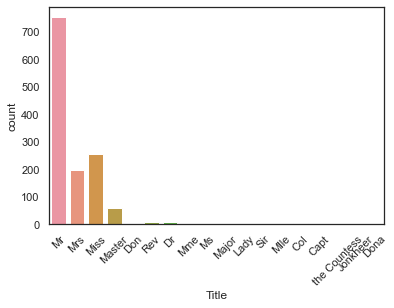

In [502]:
g = sns.countplot(data=dataset, x = 'Title')
g = plt.setp(g.get_xticklabels(), rotation=45) 

In [503]:
dataset['Title'].value_counts()

Mr              753
Miss            255
Mrs             197
Master           60
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: Title, dtype: int64

In [504]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


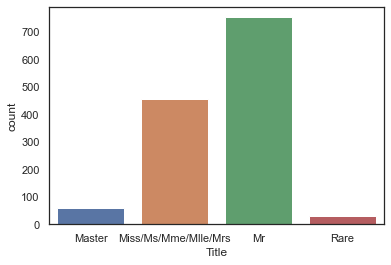

In [505]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

[Text(0, 0.5, 'Survival probability')]

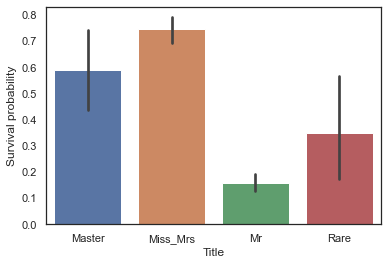

In [506]:
g = sns.barplot(data = dataset, x = 'Title', y = 'Survived')
g.set_xticklabels(["Master", "Miss_Mrs", "Mr", "Rare"])
g.set(ylabel = "Survival probability")

여자와 아이 먼저  
Rare Title가진 승객들의 생존율이 높았다

In [507]:
# Drop Name variable
dataset.drop(labels = ['Name'], axis =1, inplace = True)

## Family Size

SibSp, Parch와 승객본인(1)을 합한 Fsize(familySize)

In [508]:
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

Text(0, 0.5, 'Survival Probability')

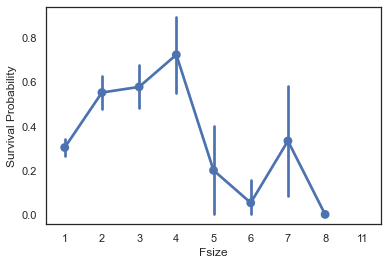

In [509]:
g = sns.pointplot(x="Fsize",y="Survived",data = dataset)
g.set_ylabel("Survival Probability")

대가족의 경우 생존율이 낮다  
가족크기를 4가지 카테고리로 나누겠다

In [510]:
dataset['Single'] = dataset['Fsize'].map(lambda s : 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s : 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s : 1 if 3 <= s <= 4else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s : 1 if s >= 5 else 0)


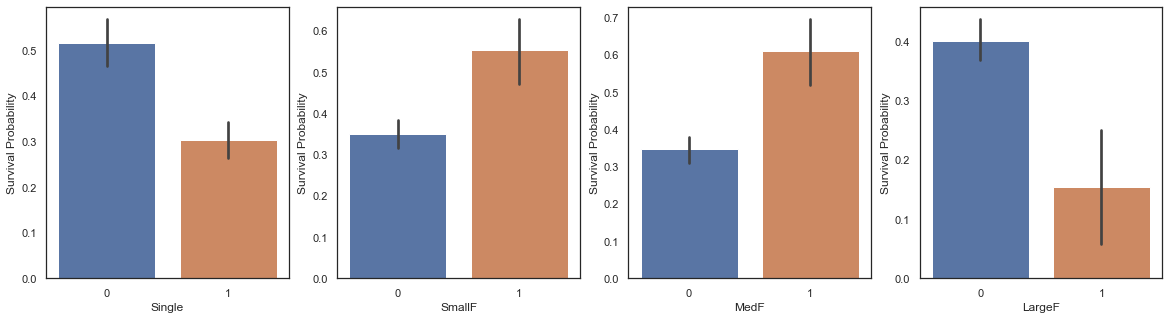

In [511]:
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
g = sns.barplot(x="Single",y="Survived",data=dataset)
g = g.set_ylabel("Survival Probability")
plt.subplot(1,4,2)
g = sns.barplot(x="SmallF",y="Survived",data=dataset)
g = g.set_ylabel("Survival Probability")
plt.subplot(1,4,3)
g = sns.barplot(x="MedF",y="Survived",data=dataset)
g = g.set_ylabel("Survival Probability")
plt.subplot(1,4,4)
g = sns.barplot(x="LargeF",y="Survived",data=dataset)
g = g.set_ylabel("Survival Probability")

small, medium일 경우 생존율이 높다

In [512]:
# convert to indicator values Title and Embarked 
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


## Cabin

In [513]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [514]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [515]:
dataset['Cabin'].isnull().sum()

1007

In [516]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [517]:
# replace the cabin number by the type of cabin X if not
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

Cabin의 맨 앞 글자가 desk를 나타냄  
승객의 위치가 표시되어 이 정보만 활용

<AxesSubplot:xlabel='Cabin', ylabel='count'>

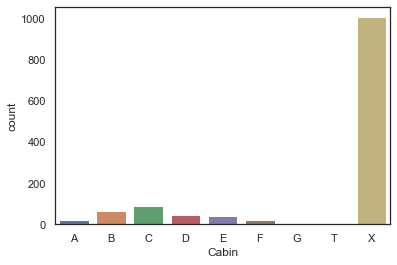

In [518]:
sns.countplot(data=dataset, x='Cabin', order = ['A','B','C','D','E','F','G','T','X'])

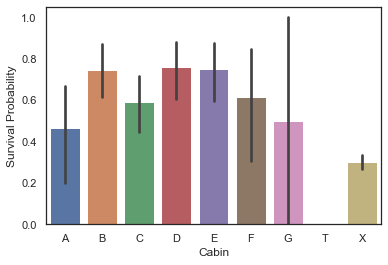

In [519]:
g = sns.barplot(y="Survived",x="Cabin",data=dataset,order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabel("Survival Probability")

객실있는 승객이 없는승객(X)보다 생존율이 높다

In [520]:
dataset = pd.get_dummies(dataset, columns = ['Cabin'], prefix = 'Cabin')

In [521]:
dataset.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Fsize', 'Single', 'SmallF', 'MedF', 'LargeF',
       'Title_0', 'Title_1', 'Title_2', 'Title_3', 'Em_C', 'Em_Q', 'Em_S',
       'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
       'Cabin_G', 'Cabin_T', 'Cabin_X'],
      dtype='object')

## Ticket

In [522]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [523]:
# Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace(".","").replace("/", "").strip().split(' ')[0])
    else:
        Ticket.append('X')
        
dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [524]:
dataset = pd.get_dummies(dataset, columns = ['Ticket'], prefix = "T")
dataset.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Fsize', 'Single', 'SmallF', 'MedF', 'LargeF', 'Title_0',
       'Title_1', 'Title_2', 'Title_3', 'Em_C', 'Em_Q', 'Em_S', 'Cabin_A',
       'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G',
       'Cabin_T', 'Cabin_X', 'T_A', 'T_A4', 'T_A5', 'T_AQ3', 'T_AQ4', 'T_AS',
       'T_C', 'T_CA', 'T_CASOTON', 'T_FC', 'T_FCC', 'T_Fa', 'T_LINE', 'T_LP',
       'T_PC', 'T_PP', 'T_PPP', 'T_SC', 'T_SCA3', 'T_SCA4', 'T_SCAH', 'T_SCOW',
       'T_SCPARIS', 'T_SCParis', 'T_SOC', 'T_SOP', 'T_SOPP', 'T_SOTONO2',
       'T_SOTONOQ', 'T_SP', 'T_STONO', 'T_STONO2', 'T_STONOQ', 'T_SWPP',
       'T_WC', 'T_WEP', 'T_X'],
      dtype='object')

In [525]:
# create categorical values for Pclass
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix = 'Pc')
dataset.columns

Index(['PassengerId', 'Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Fsize', 'Single', 'SmallF', 'MedF', 'LargeF', 'Title_0', 'Title_1',
       'Title_2', 'Title_3', 'Em_C', 'Em_Q', 'Em_S', 'Cabin_A', 'Cabin_B',
       'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T',
       'Cabin_X', 'T_A', 'T_A4', 'T_A5', 'T_AQ3', 'T_AQ4', 'T_AS', 'T_C',
       'T_CA', 'T_CASOTON', 'T_FC', 'T_FCC', 'T_Fa', 'T_LINE', 'T_LP', 'T_PC',
       'T_PP', 'T_PPP', 'T_SC', 'T_SCA3', 'T_SCA4', 'T_SCAH', 'T_SCOW',
       'T_SCPARIS', 'T_SCParis', 'T_SOC', 'T_SOP', 'T_SOPP', 'T_SOTONO2',
       'T_SOTONOQ', 'T_SP', 'T_STONO', 'T_STONO2', 'T_STONOQ', 'T_SWPP',
       'T_WC', 'T_WEP', 'T_X', 'Pc_1', 'Pc_2', 'Pc_3'],
      dtype='object')

In [526]:
# drop useless variables
dataset.drop(labels = ["PassengerId"], axis = 1, inplace=True)
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


# Modeling

In [529]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(["Survived"],axis = 1,inplace=True)

In [530]:
#train['Survied'] = train['Survived'].astype(int)
Y_train = train['Survived']
X_train = train.drop(['Survived'],axis = 1)

## Simple modeling

### Cross validation models 
* SVC
* Decision Tree
* AdaBoost
* Random Forest
* Extra Trees
* Gradient Boosting
* Multiple layer perceprton (neural network)
* KNN
* Logistic regression
* Linear Discriminant Analysis

In [531]:
kfold = StratifiedKFold(n_splits = 10)

[Text(0.5, 0, 'Mean Accuracy'), Text(0.5, 1.0, 'Cross Validation scores')]

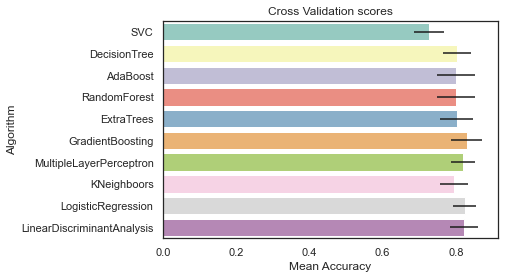

In [532]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state = random_state))
classifiers.append(DecisionTreeClassifier(random_state = random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(
    random_state = random_state), random_state = random_state, learning_rate= 0.1))
classifiers.append(RandomForestClassifier(random_state = random_state))
classifiers.append(ExtraTreesClassifier(random_state = random_state))
classifiers.append(GradientBoostingClassifier(random_state = random_state))
classifiers.append(MLPClassifier(random_state = random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier,
                                      X_train, Y_train, scoring= 'accuracy', cv = kfold, n_jobs=4))
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot(x = "CrossValMeans", y = "Algorithm", data = cv_res, palette = 'Set3', orient = 'h', **{'xerr':cv_std})
g.set(xlabel = 'Mean Accuracy', title = 'Cross Validation scores')

choose to SVC, AdaBoost, RandomForest, ExtraTrees and the GradientBoosting classifiers for the ensemble modeling

### Hyper parameter tunning for best models

Using GridSearch CV

In [533]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


In [534]:
gsadaDTC.best_score_

0.8241317671092953

In [535]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8286133810010214

In [536]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.832035240040858

In [537]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.833158835546476

In [538]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

### Plot learning curves

learning curve는 train set에 대한 overfitting 효과와 accuracy에 미치는 영향을 볼 수 있다

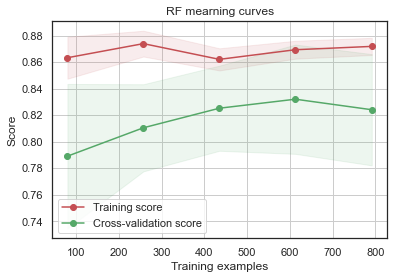

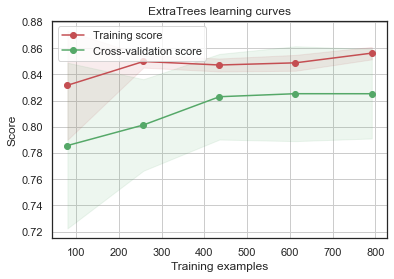

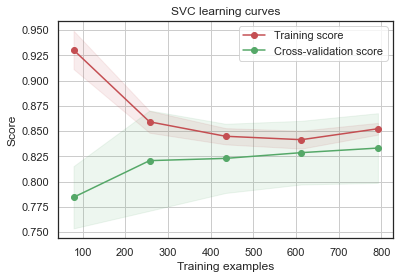

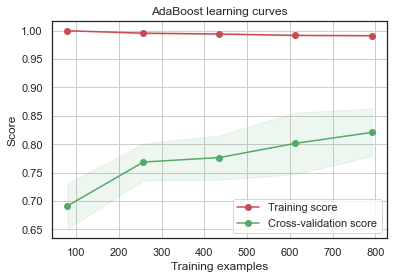

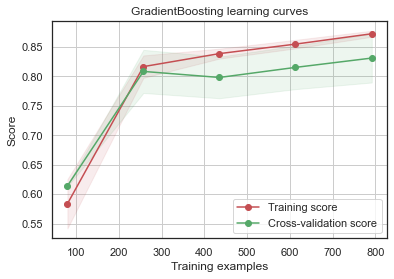

In [539]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

GradientBossting, AdaBoost는 overfit the training set  
증가하는 cross_validation 곡선에 따르면 더 많은 training example들로 더 나은 성능 발휘할 수 있다  
SVC, ExtraTree는 두 곡선이 서로 가깝기 떄문에 예측을 더 잘 일반화하는 것으로 보임

### Feature importance of the tree based classifiers

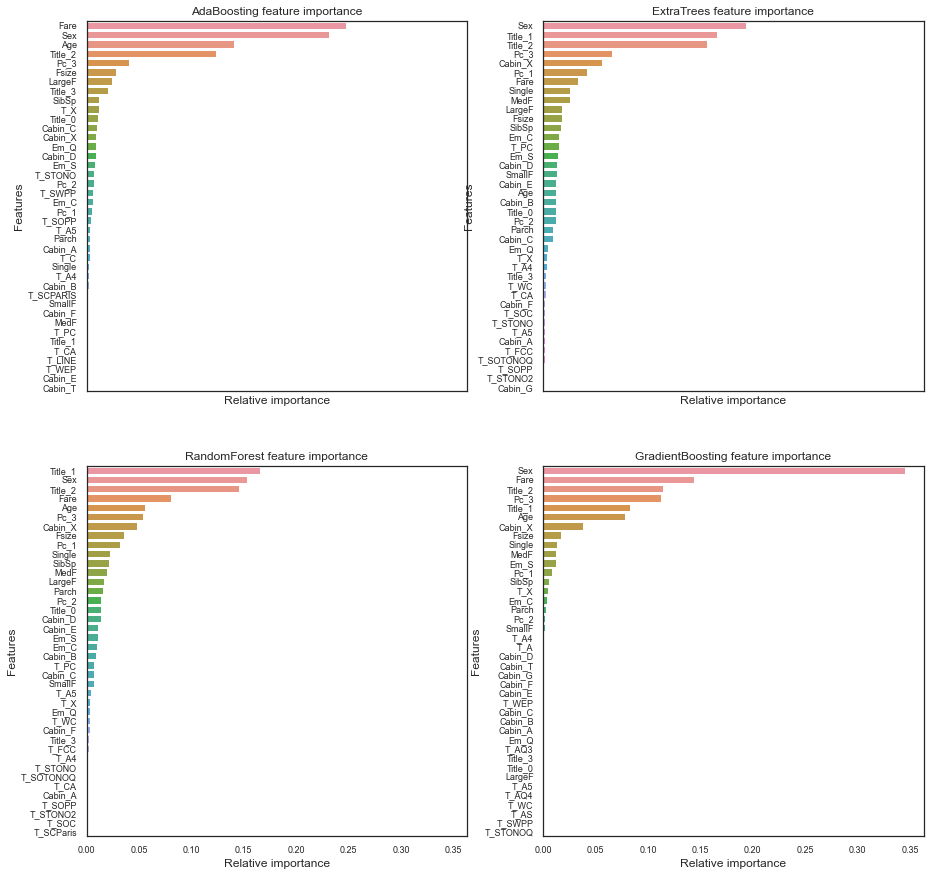

In [540]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

 Title_2,3은 Sex와 상관관계가 높다  
 Pc들(Pclass) 및 Fare는 승객의 사회적 지위를 의미  
 Age 및 title_1은 승객의 나이를 의미  
 
 
 생존예측은 배 안의 위치보다 나이,성별,가족규모,승객의 사회적 지위와 더 연관있다

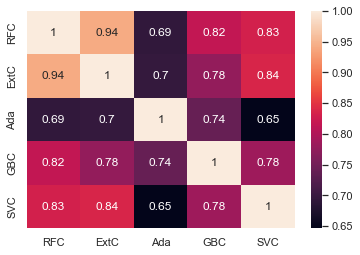

In [541]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

## Ensemble modeling

### Combining models

5개의 분류기에서 나오는 예측을 결합하기 위해 voting classifier을 선택  


In [545]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

## Prediction

### Predict and Submit results

In [546]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)